# Final Project: House Price Prediction
## Corpus Christi Team
### Step 5 (Machine Learning Model for House Prediction)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import plot_importance

from shapash.explainer.smart_explainer import SmartExplainer

import re
import os
import glob
from datetime import datetime as dt
import warnings
from time import sleep
from tqdm import tqdm

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

#### Read the input data conditioned for ML

In [2]:
data_path = "../03_Data_Cleaning/data/*.csv"
listing = glob.glob(data_path)
latest_file = max(listing, key=os.path.getctime)
print(f'The file selected is: {latest_file}')

# Create the input DF
df = pd.read_csv(latest_file)
df

The file selected is: ../03_Data_Cleaning/data\03b_preprocessed4ML_data_Houston_TX_Houses_merged_2023_1_8_12_2.csv


,Lat,Lng,Price,Bedrooms,Bathrooms,constructedArea,zipCode,CountyId,taxRate,hasGarage,hasPool,hasCooling,hasView,yearBuilt,stories,parkingSpaces,schoolElemRating,schoolElemDist,schoolMidRating,schoolMidDist,schoolHighRating,schoolHighDist,priceIncreased,priceDiff,days,lotAreaSQFT,avgSchoolRating,avgSchoolDist
0,29.603600,-95.485405,276000,3.0,2,3612.0,77489,2698,2.41,1,0,1,0,1971.0,2.0,2,6.0,0.5,3,1.3,2,1.1,1,31000,1213,8764.272000,3.666667,0.966667
1,29.600388,-95.488210,220000,3.0,2,1270.0,77489,2698,2.41,1,0,1,0,1972.0,1.0,1,6.0,0.3,3,1.3,2,1.0,1,65100,503,7884.360000,3.666667,0.866667
2,29.595436,-95.485880,230000,4.0,2,1765.0,77489,2698,2.41,1,0,1,0,1974.0,1.0,2,6.0,0.3,3,1.0,2,0.6,1,115275,5140,7148.196000,3.666667,0.633333
3,29.597320,-95.492690,225000,3.0,2,1444.0,77489,2698,2.41,1,0,1,0,1978.0,1.0,2,6.0,0.1,3,1.4,2,1.0,1,56000,824,7731.900000,3.666667,0.833333
4,29.592060,-95.489050,246500,3.0,2,1738.0,77489,2698,2.41,1,0,1,0,1978.0,1.0,2,6.0,0.3,3,1.0,2,0.6,1,41500,6810,8062.956000,3.666667,0.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,29.808900,-95.408710,669900,3.0,3,2576.0,77008,1090,2.29,1,0,1,0,2022.0,2.0,2,5.0,0.3,5,0.7,5,1.3,1,404900,3993,3275.000000,5.000000,0.766667
4496,29.775753,-95.407600,519000,3.0,4,2513.0,77007,1090,2.29,1,0,1,0,2006.0,3.0,2,8.0,1.2,6,1.6,5,1.5,1,522400,4145,2330.460000,6.333333,1.433333
4497,29.685492,-95.371700,550000,1.0,2,5160.0,77021,1090,2.29,1,0,1,0,1952.0,1.0,2,2.0,0.3,3,0.6,2,2.5,1,375000,4219,14999.999997,2.333333,1.133333
4498,29.778660,-95.415340,450000,3.0,4,2148.0,77007,1090,2.29,1,0,1,0,2007.0,3.0,2,4.0,1.0,6,2.0,3,2.7,0,0,0,2051.676000,4.333333,1.900000


#### Do some additional ML conditioning based on previous testing

In [3]:
# Based on previous testing, remove low-weight and unnecessary features
df = df.drop(['days', 'priceDiff', 'priceIncreased', 'Lat', 'Lng', 'schoolElemRating', 'schoolMidRating', 'schoolHighRating', 'schoolElemDist', 'schoolMidDist', 'schoolHighDist', 'hasView', 'hasCooling', 'hasPool'], axis=1)

#### Perform basic QC on the input DF

In [4]:
# Check if there are any null values
df.isnull().sum()

Price              0
Bedrooms           0
Bathrooms          0
constructedArea    0
zipCode            0
CountyId           0
taxRate            0
hasGarage          0
yearBuilt          0
stories            0
parkingSpaces      0
lotAreaSQFT        0
avgSchoolRating    0
avgSchoolDist      0
dtype: int64

In [5]:
# Get statistics
df.describe()

,Price,Bedrooms,Bathrooms,constructedArea,zipCode,CountyId,taxRate,hasGarage,yearBuilt,stories,parkingSpaces,lotAreaSQFT,avgSchoolRating,avgSchoolDist
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,401480.002667,3.393151,2.830667,2158.662015,77070.912667,1109.359333,2.291353,0.834222,1993.302420,1.700003,1.780889,7776.873718,108.415534,105.570933
std,157007.688575,0.724712,0.887162,711.170309,81.504576,175.732117,0.013565,0.371922,28.878506,0.718844,1.450062,22153.124331,304.181863,305.144595
min,200000.000000,0.000000,0.000000,0.000000,77003.000000,1090.000000,2.020000,0.000000,1888.000000,1.000000,0.000000,0.000000,2.000000,0.166667
25%,280000.000000,3.000000,2.000000,1680.750000,77022.000000,1090.000000,2.290000,1.000000,1970.000000,1.000000,2.000000,4225.757000,3.333333,0.933333
50%,364000.000000,3.000000,3.000000,2020.000000,77057.000000,1090.000000,2.290000,1.000000,2003.000000,2.000000,2.000000,6993.558000,4.333333,1.333333
75%,469990.000000,4.000000,3.000000,2528.250000,77084.000000,1090.000000,2.290000,1.000000,2022.000000,2.000000,2.000000,8160.000000,6.000000,1.966667
max,900000.000000,10.000000,7.000000,6793.000000,77598.000000,2983.000000,2.410000,1.000000,2023.000000,5.000000,49.000000,980100.000000,999.000000,999.000000


<AxesSubplot:>

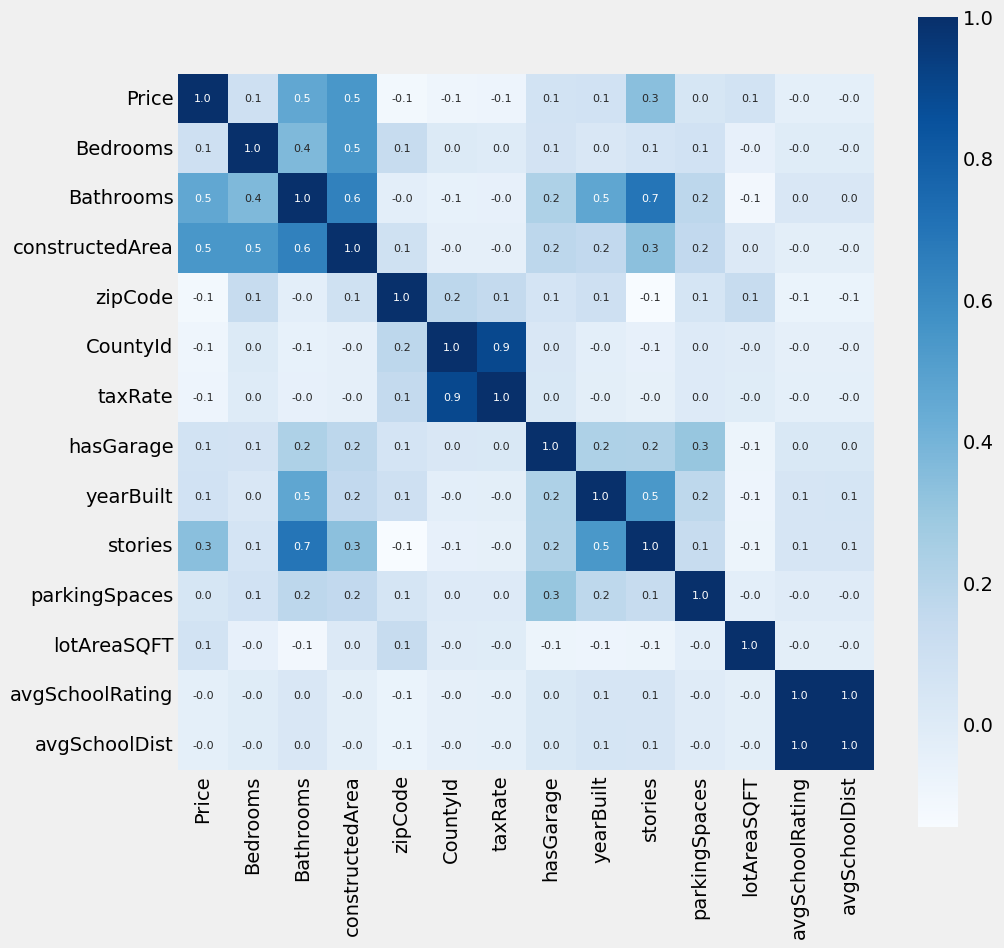

In [6]:
# Heat map
# A heat map shows the correlation between the input data columns
# There are 2 types of correlation:
# Positive: As the magnitude of a feature increases, the magnitude of a correlated feature increases
# Negative: As the magnitude of a feature increases, the magnitude of a correlated feature decreases
correlation = df.corr()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

#### Get the features and the target column

In [7]:
# Create a new DataFrame that holds only the cryptocurrencies names.
# X = Features, y = target
X = df.drop('Price', axis=1)
y = df[["Price"]]

#### Split the data for training and testing

In [8]:
# Use 20% of data for testing. Use a random_state = 2 to be able to reproduce the splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
print(X.shape, X_train.shape, X_test.shape)

(4500, 13) (3600, 13) (900, 13)


#### Model Training

In [9]:
# Load the model (XGBoost Regressor)
model = XGBRegressor()

# Train the model with the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

#### Make predictions using the test data

In [10]:
y_pred = model.predict(X_test)

# Calculate the R squared error
error_r2 = metrics.r2_score(y_test, y_pred)

# Calculate the mean absolute error
error_ma = metrics.mean_absolute_error(y_test, y_pred)

print(f'R squared error: {error_r2} (should be close to 1)')

R squared error: 0.7645602747879283 (should be close to 1)


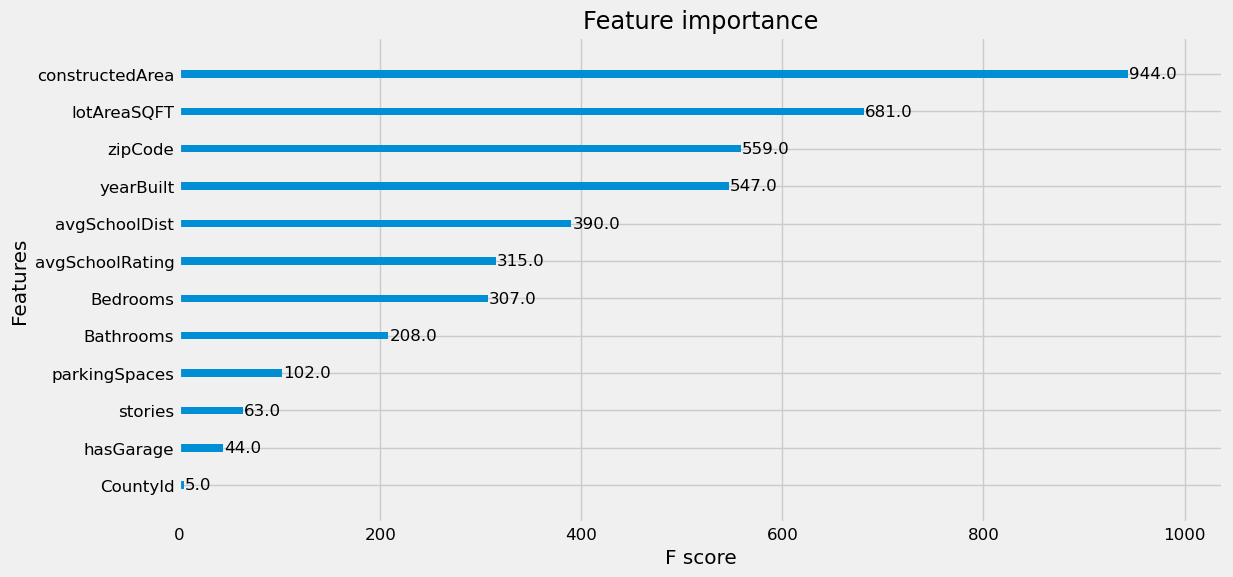

In [11]:
# Plot the features importance
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12,6))
plot_importance(model, ax=ax)
plt.show();

In [12]:
# Display the actual price vs the predicted price
y_test_df = y_test.reset_index(drop=True)
y_test_df = y_test_df.rename(columns = {'Price':'Actual_Price'})

y_pred_df = pd.DataFrame(y_pred, columns = ['Predicted_Price'])
y_pred_df = y_pred_df['Predicted_Price'].apply(np.ceil).astype('int')

# Display the actual and the predicted prices side by side
df_prices = pd.concat([y_test_df, y_pred_df], axis=1)
df_prices

,Actual_Price,Predicted_Price
0,250000,278977
1,260000,255327
2,409990,471866
3,825000,719738
4,599900,601181
...,...,...
895,474500,363870
896,249500,231963
897,399900,366376
898,599000,524110


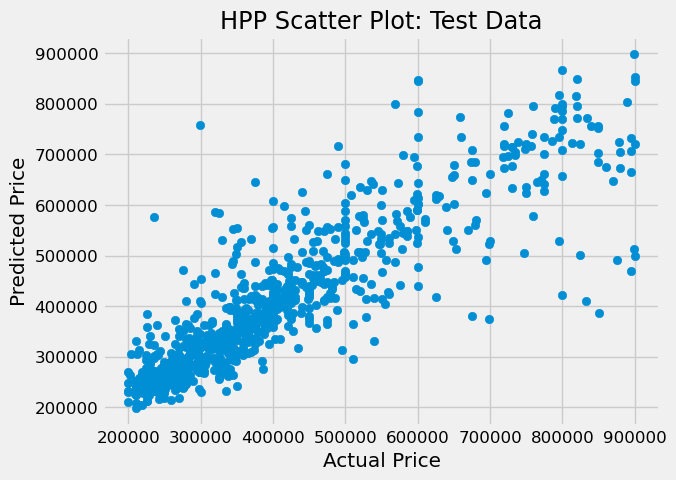

In [13]:
# Scatter Plot using test data
plt.scatter(y_test_df, y_pred_df)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('HPP Scatter Plot: Test Data')
plt.show()

### Understanding the model with Shapash
#### If not installed, run the following command in your conda environment
!pip install shapash

In [14]:
# Initialize shapash with the ML model
xpl = SmartExplainer(model)

In [15]:
# Condition X_test and y_pred for Shapash
# Display the actual price vs the predicted price
temp = X_test.reset_index(drop=True)
sp_X_test = temp.rename(columns = {'Price':'Price'})
del(temp)

temp = pd.DataFrame(y_pred, columns = ['Price'])
sp_y_pred = temp['Price'].apply(np.ceil).astype('int')
del(temp)

temp = y_test.reset_index(drop=True)
sp_y_target = temp.rename(columns = {'Price':'Price'})
del(temp)

In [16]:
# Compile shapash
xpl.compile(x=sp_X_test, y_pred=sp_y_pred, y_target=sp_y_target)

In [17]:
app = xpl.run_app(title_story='House_Price_Prediction')

Dash is running on http://0.0.0.0:8050/



INFO:root:Your Shapash application run on http://Oscar:8050/
INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8050/

INFO:root:Use the method .kill() to down your app.


 * Serving Flask app 'shapash.webapp.smart_app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [18]:
# Plot a summary with the contribution of the features
summary_df = xpl.to_pandas(max_contrib=14) #Number of max features to show in summary
summary_df.head()

INFO:werkzeug: * Running on http://192.168.1.228:8050/ (Press CTRL+C to quit)


,Price,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3,feature_4,value_4,contribution_4,feature_5,value_5,contribution_5,feature_6,value_6,contribution_6,feature_7,value_7,contribution_7,feature_8,value_8,contribution_8,feature_9,value_9,contribution_9,feature_10,value_10,contribution_10,feature_11,value_11,contribution_11,feature_12,value_12,contribution_12,feature_13,value_13,contribution_13
0,278977,zipCode,77489.0,-46481.570312,yearBuilt,1979.0,-41629.429688,lotAreaSQFT,6298.776,-16772.03125,avgSchoolRating,3.666667,-13456.001953,constructedArea,2296.0,12561.021484,Bathrooms,3.0,-7394.222168,CountyId,2698.0,-7291.645996,Bedrooms,4.0,-1111.905518,avgSchoolDist,1.566667,853.761353,stories,2.0,-329.857422,hasGarage,1.0,260.294617,parkingSpaces,2.0,180.408295,taxRate,2.41,0.0
1,255327,constructedArea,1500.0,-84425.648438,avgSchoolRating,3.666667,-22105.853516,yearBuilt,1946.0,17938.378906,lotAreaSQFT,7775.70134,-16156.06543,Bedrooms,4.0,-7828.75293,parkingSpaces,0.0,-7722.29541,avgSchoolDist,1.166667,-7640.489258,hasGarage,0.0,-6948.653809,zipCode,77021.0,-6193.191895,Bathrooms,2.0,-4334.573242,stories,1.0,989.530029,CountyId,1090.0,166.239365,taxRate,2.29,0.0
2,471866,yearBuilt,2022.0,44680.066406,zipCode,77011.0,37452.238281,avgSchoolRating,3.666667,-21504.4375,lotAreaSQFT,10001.376,21064.314453,Bedrooms,3.0,8810.224609,Bathrooms,3.0,-7310.475586,constructedArea,1926.0,-7130.295898,parkingSpaces,2.0,-4045.631836,hasGarage,1.0,797.60321,avgSchoolDist,0.666667,-622.322388,CountyId,1090.0,173.352127,stories,2.0,-87.180779,taxRate,2.29,0.0
3,719738,constructedArea,3530.0,194236.1875,zipCode,77079.0,60997.871094,Bathrooms,4.0,56595.070312,yearBuilt,1978.0,-41702.957031,Bedrooms,3.0,30791.583984,avgSchoolRating,5.333333,24430.576172,stories,2.0,-6593.602539,avgSchoolDist,0.6,-3364.69751,lotAreaSQFT,8637.948,2780.242188,parkingSpaces,2.0,1086.144043,hasGarage,1.0,715.909363,CountyId,1090.0,177.267578,taxRate,2.29,0.0
4,601181,zipCode,77004.0,102772.109375,constructedArea,2610.0,70204.570312,yearBuilt,2023.0,37293.71875,avgSchoolRating,4.0,-30445.390625,avgSchoolDist,2.0,-12600.250977,lotAreaSQFT,3249.576,12502.423828,Bedrooms,3.0,12282.579102,Bathrooms,4.0,6129.799316,stories,4.0,2930.789551,hasGarage,1.0,1737.535034,parkingSpaces,2.0,-1309.649048,CountyId,1090.0,94.451538,taxRate,2.29,0.0


In [20]:
# Kill the dashboard (Run when done)
#app.kill

<bound method CustomThread.kill of <CustomThread(Thread-6, started 28812)>>